In [3]:
import numpy as np 
import matplotlib.pyplot as plt
from tqdm import tqdm

100%|██████████| 25/25 [00:01<00:00, 12.93it/s]


ValueError: x and y can be no greater than 2D, but have shapes (25,) and (25, 1, 1)

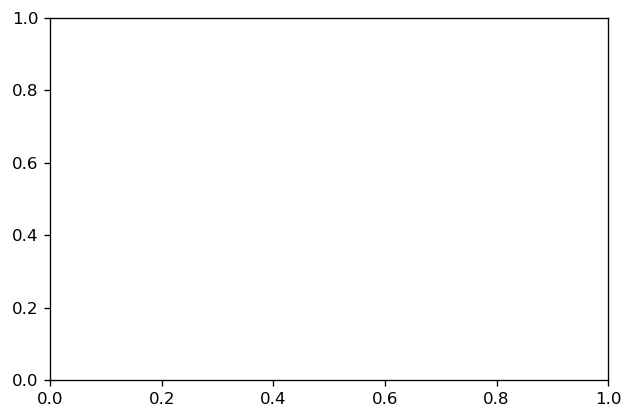

In [38]:
def dataset(size =  200, timesteps = 25):
    x, y = [], []
    sin_wave = np.sin(np.arange(size))
    for step in range(sin_wave.shape[0]-timesteps):
        x.append(sin_wave[step:step+timesteps])
        y.append(sin_wave[step+timesteps])
    return np.array(x).reshape(len(y),timesteps,1),np.array(y).reshape(len(y),1)

class RNN:
    def __init__(self, x, y, hidden_units):
        self.x = x # shape [samples, timesteps, features]
        self.y = y # shape [samples, outputs]
        self.hidden_units = hidden_units
        self.Wx = np.random.randn(self.hidden_units, self.x.shape[2])
        self.Wh = np.random.randn(self.hidden_units, self.hidden_units)
        self.Wy = np.random.randn(self.y.shape[1],self.hidden_units)
    
    def cell(self, xt, ht_1):
        ht = np.tanh(np.dot(self.Wx,xt.reshape(1,1)) + np.dot(self.Wh,ht_1))
        self.yt = np.dot(self.Wy,ht)
        return ht
        
    def forward(self, sample):
        sample_x, sample_y = self.x[sample], self.y[sample]
        ht = np.zeros((self.hidden_units,1)) # first hidden state is zeros vector
        self.hidden_states = [ht] # collection of hidden states for each sample
        self.inputs = [] # collection of inputs for each sample
        for step in range(len(sample_x)):
            ht = self.cell(sample_x[step],ht)
            self.inputs.append(sample_x[step].reshape(1,1))
            self.hidden_states.append(ht)
            self.error = self.yt - sample_y
            self.loss = self.error**2
            
    
    def backward(self):
        n = len(self.inputs)
        dyt = self.error # dL/dyt
        dWy = np.dot(dyt,self.hidden_states[-1].T) # dyt/dWy
        dht = np.dot(dyt, self.Wy).T # dL/dht = dL/dyt * dyt/dht ,where ht = tanh(Wx*xt + Wh*ht))
        dWx = np.zeros(self.Wx.shape)
        dWh = np.zeros(self.Wh.shape)
        # BPTT
        for step in reversed(range(n)):
            temp = (1-self.hidden_states[step+1]**2) * dht # dL/dtanh = dL/dyt * dyt/dht * dht/dtanh, where dtanh = (1-ht**2) 
            dWx += np.dot(temp, self.inputs[step].T) # dL/dWx = dL/dyt * dyt/dht * dht/dtanh * dtanh/dWx
            dWh += np.dot(temp, self.hidden_states[step].T) # dL/dWh = dL/dyt * dyt/dht * dht/dtanh * dtanh/dWh

            dht = np.dot(self.Wh, temp) # dL/dht-1 = dL/dht * (1 - ht+1^2) * Whh
        dWy = np.clip(dWy, -1, 1)
        dWx = np.clip(dWx, -1, 1)
        dWh = np.clip(dWh, -1, 1)
        self.Wy -= self.lr * dWy
        self.Wx -= self.lr * dWx
        self.Wh -= self.lr * dWh
        
    def train(self, epochs, learning_rate):
        self.Ovr_loss = []
        self.lr = learning_rate
        for epoch in tqdm(range(epochs)):
            for sample in range(self.x.shape[0]):
                self.forward(sample)
                self.backward()
            self.Ovr_loss.append(self.loss / self.x.shape[0])
            self.loss = 0
            
        plt.figure(dpi=120)
        plt.plot(self.Ovr_loss)
            
x,y = dataset()
rnn = RNN(x,y,64)
rnn.train(25,1e-2)

In [30]:


class RNN:
    def __init__(self, data, timesteps = 25, epochs = 50, units = 80, lr = 1e-2):
        self.timesteps = timesteps
        self.data = data
        self.epochs = epochs
        self.lr = lr 
        self.units = units # hidden cells 
        self.m = self.data.shape[0]
        
        # One to one
        self.in_dim = 1
        self.out_dim = 1 
        
        self.weight_init()
        self.seq_X, self.seq_Y = self.sequence_data(self.data)
        
        self.hidden = []
        self.inputs = []
        self.Loss = []
        self.outputs = []
        self.s = []
        
    
    def weight_init(self):
        self.Wx = np.random.randn(self.units,self.in_dim) 
        self.Wh = np.random.randn(self.units,self.units)  
        self.Wy = np.random.randn(self.out_dim,self.units)
        
    def sequence_data(self, data):
        x, y = [], []
        for i in range(data.shape[0]-self.timesteps):
            x.append(data[i:i+self.timesteps])
            y.append(data[i+self.timesteps])

        return np.array(x), np.array(y)
        
    def sigmoid(self,z):
        z = np.clip(z, -88.72, 88.72)
        return (1 / (1 + np.exp(-z)))
    
    def dsigmoid(self,z):
        return self.sigmoid(z) * (1 - self.sigmoid(z))
    
    def dtanh(self,z):
        return 1-z**2
    
    def relu(self,z):
        return np.maximum(0,z)
    
    def drelu(self,z):
        z[z<=0] = 0
        z[z>0] = 1
        return z
        
    def cell(self,x):
        xt = np.dot(self.Wx,x.reshape(1,1))
        ht = np.dot(self.Wh,self.ht)
        s = xt + ht
        ht1 = np.tanh(s)
        
        self.output = np.dot(self.Wy,ht1)
        self.ht = ht1    
        
    def forward(self, x, y):
        self.inputs = []
        self.hidden = []
        self.s = []
        self.ht = np.zeros((self.units,1))
        self.hidden = [self.ht]
        
        for step in range(self.timesteps):    
            self.cell(x[step])
            self.hidden.append(self.ht)
            self.inputs.append(x[step].reshape(1,1))
            
        self.error = self.output - y
        self.loss = 0.5*(self.error**2)
        self.outputs.append(self.output)
        
    def gradient_clip(self, W):
        return np.clip(W, -1, 1)
                        
    def backward(self):
        n = len(self.inputs)
        dyt = self.error # dL/dyt
        dWy = np.dot(dyt,self.hidden[n].T) # dyt/dWy
                
        dWx = np.zeros((self.Wx.shape))
        dWh = np.zeros((self.Wh.shape))
        
        dht = np.dot(dyt, self.Wy).T # dL/dyt * dyt/dht ,where ht = tanh(Wx*xt + Wh*ht))
        
        for step in reversed(range(n)):
            temp = self.dtanh(self.hidden[step+1]) * dht
            print(temp.shape)
                
            dWx += np.dot(temp, self.inputs[step].T)
            dWh += np.dot(temp, self.hidden[step].T) 
            
            dht = np.dot(self.Wh, temp)
            
        # Update
        
        dWy = self.gradient_clip(dWy)
        dWh = self.gradient_clip(dWh)
        dWx = self.gradient_clip(dWx)
        
        self.Wy -= self.lr * dWy
        self.Wx -= self.lr * dWx
        self.Wh -= self.lr * dWh
            
    def train(self):
        for epoch in tqdm(range(self.epochs)):
            self.loss = 0
            for x,y in zip(self.seq_X, self.seq_Y):
                self.forward(x,y)
                self.backward()
            self.Loss.append(np.squeeze(self.loss / self.m))
            idx = np.random.randint(0,self.m)
            self.outputs = []
rnn = RNN(train_data)
rnn.train()
plt.figure(dpi=120)
plt.plot(rnn.Loss)
print((time.time()-start))


NameError: name 'train_data' is not defined

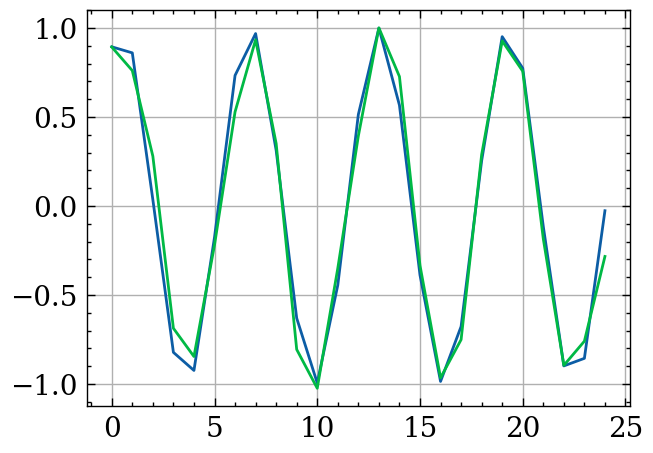

In [324]:
test_x, test_y = rnn.sequence_data(test_data)
rnn.outputs = []
for x,y in zip(test_x, test_y):
    rnn.loss = 0
    rnn.forward(x,y)

plt.figure(dpi = 200)
plt.grid()
plt.plot([i for i in range(test_y.shape[0])], test_y, np.array(rnn.outputs).reshape(test_x.shape[0],1))


In [325]:
np.mean((np.mean(np.array(rnn.outputs).reshape(test_x.shape[0],1) - test_y))) * 100

-0.7581956105314145

0.17190498203996132

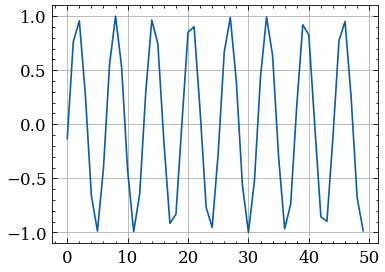

In [273]:
plt.figure(dpi=120)
plt.plot(rnn.seq_Y[:50])
plt.grid()
plt.savefig('Train.png')

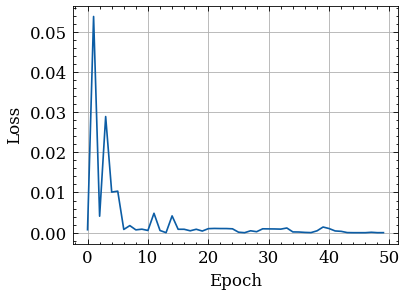

In [294]:
plt.figure(dpi=120)
plt.plot(rnn.Loss)
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('Loss.png')

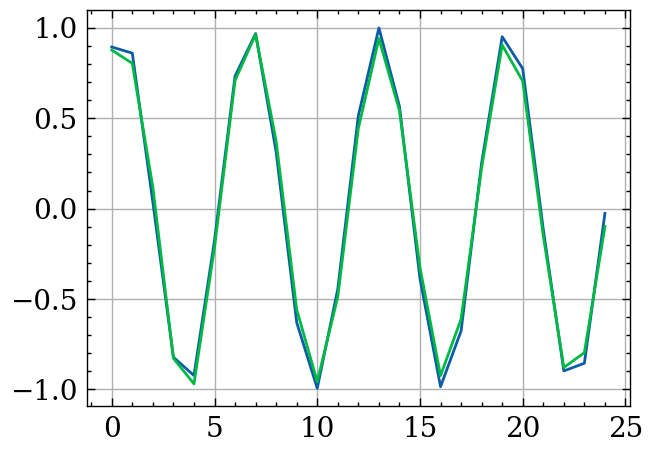

In [295]:
plt.figure(dpi = 200)
plt.grid()
plt.plot([i for i in range(test_y.shape[0])], test_y, np.array(rnn.outputs).reshape(test_x.shape[0],1))
plt.savefig('Predictions.png')